# Secret Whiteboard

## Team Members

Fenno Boomgaarden (Fach-Bachelor Informatik)

Hauke Redemann (Fach-Bachelor Informatik)

Keno Rott (Fach-Bachelor Informatik)

# Use cases

## Privacy in real-life video streaming

- In common screen-capturing softwares like OBS it is possible to select which windows with non-sensitive information are captured.
- Streaming in real-life **has no mechanisms** like that.
- The only option to protect the personal information of the streamer and/or others is **image processing**.
- **Hide sensitive information** while streaming on platforms like YouTube and Twitch.

For example a streamer shows his/her appartment to his/her viewers and (s)he has some sensitive information on the kitchen fridge (s)he wants to hide.

## Lecture recording software

- Some universities use **automated systems** for lecture recording.
- Lectures may contain **sensistive data** that should not be public:
  - Access credentials to private webservers
  - Copyrighted information
  - Solutions for exam exercises (so they can be used again in the future)
- Provide a way to hide sensitive information **without manually editing** the video.

# Project Milestones

## 0. Project Setup

### Install dependencies

In [18]:
#!pip install opencv-python==4.1.1.26

### Imports

In [19]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
import math

### Helper functions

In [20]:
def plot_imgs(img_array, cmap="gray"):
    cols = 2
    rows = math.ceil(len(img_array)/cols)
    plt.figure(figsize=(20,5 * rows))
    for i, img in enumerate(img_array):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap)
    plt.show()

# based on https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def order_points(points):
    pts = np.float32(points)
    r = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    r[0] = pts[np.argmin(s)]
    r[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    r[1] = pts[np.argmin(diff)]
    r[3] = pts[np.argmax(diff)]

    return r

### Read images


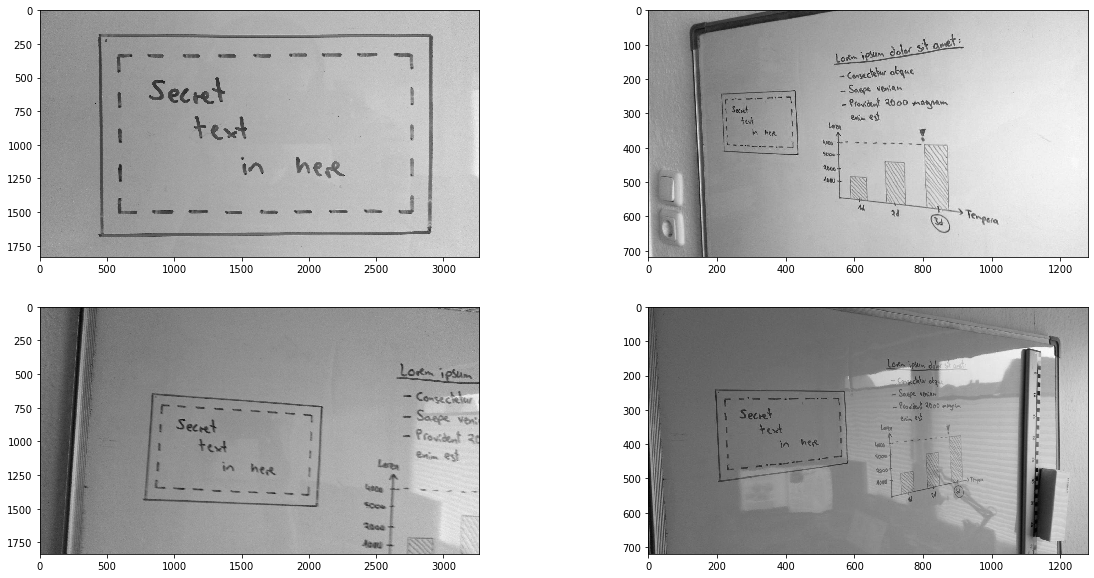

In [21]:
img_paths = [
    "https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-secret-whiteboard/master/img/samples/sample0.jpg",
    "https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-secret-whiteboard/master/img/samples/sample5.jpg",
    "https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-secret-whiteboard/master/img/samples/sample6.jpg",
    "https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-secret-whiteboard/master/img/samples/sample7.jpg"
]
    
def read_img(path):
    return io.imread(path)

original_imgs = [read_img(img_path) for img_path in img_paths]
grayscale_imgs = [cv.cvtColor(original_img, cv.COLOR_BGR2GRAY) for original_img in original_imgs]
    
plot_imgs(grayscale_imgs)

## 1. Preprocessing
Differentiate the drawing from the whiteboard background and filter out light reflections.
- Gaussian Blur (https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html)
- Adaptive Thresholding (https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html)
- Erosion/Dilatation (https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html)
- Canny Edge Detection

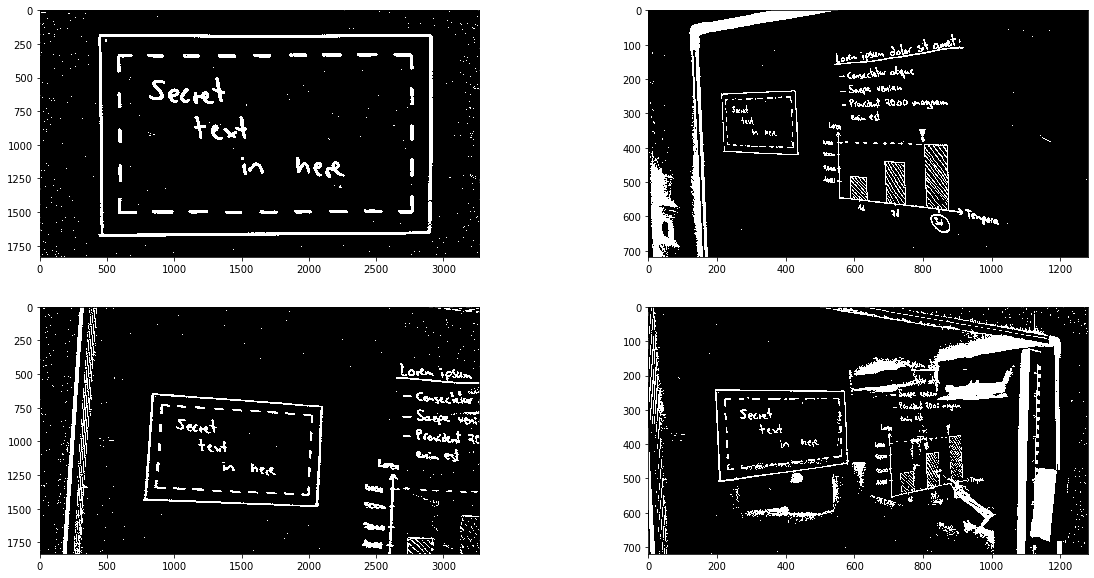

In [22]:
def apply_threshold(img):
    out = cv.GaussianBlur(img, (5,5), 0)
    out = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 201, 8)
    return out 

thresholded_imgs = [apply_threshold(img) for img in grayscale_imgs]
plot_imgs(thresholded_imgs)

## 2. Contour detection and approximation
Detect all contours in the thresholded image and approximate contours with less vertices.
- Contour detection (https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html)
- Contour approximation (https://docs.opencv.org/master/dd/d49/tutorial_py_contour_features.html)

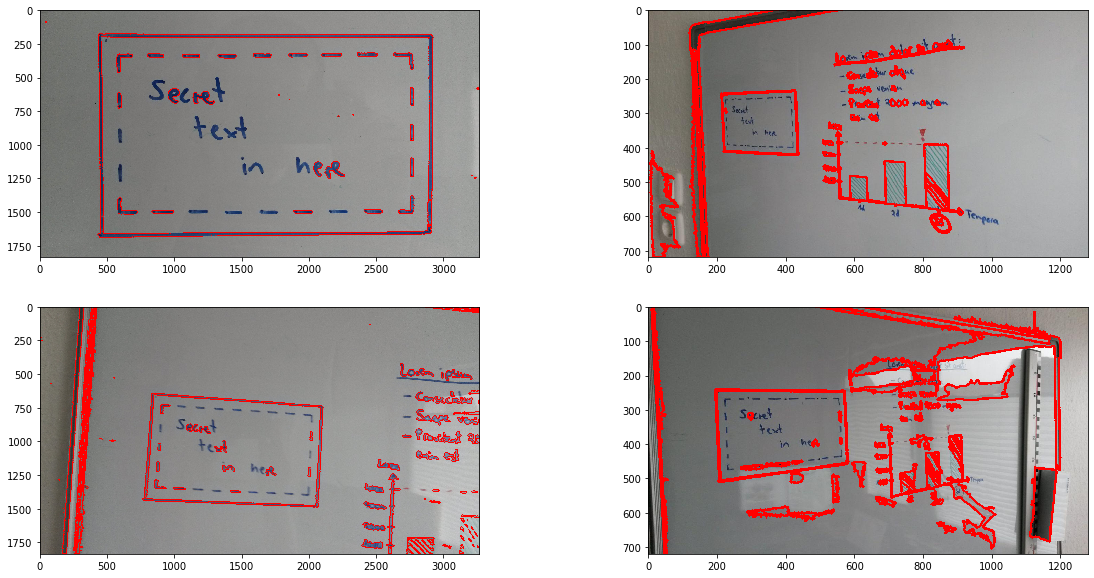

In [23]:
 def find_contours_filtered(img):
    contours, hierarchy = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    for i, element in reversed(list(enumerate(hierarchy[0]))):
        if element[2] < 0:
            del contours[i]
    
    return contours

filtered_contours_array = [find_contours_filtered(img) for img in thresholded_imgs]
display_contours = [cv.drawContours(original_img.copy(), contours, -1, (255,0,0), 5) for original_img, contours in zip(original_imgs, filtered_contours_array)]

plot_imgs(display_contours)

## 3. Shape recognition
Detect rectangles based on the number of boundary points of the approximated contour, contour properties and all angles.

- Number of boundary points = 4?
- How rectangular is the shape?

  $Extent = \frac{Object Area}{Bounding Rectangle Area}$
  
- Angles = 90°?

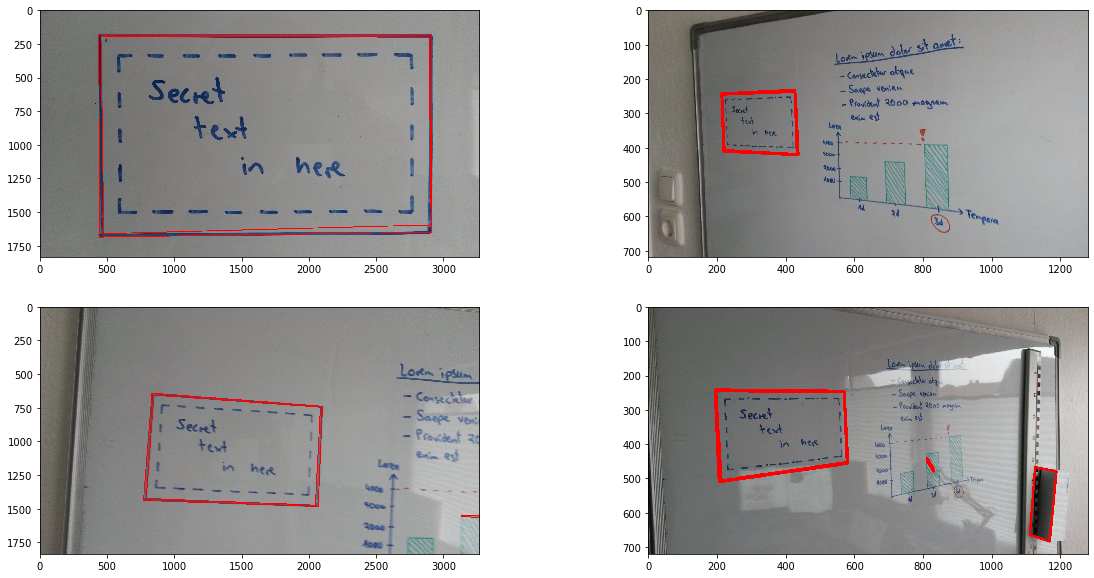

In [24]:
def detect_rectangles(contours):
    rectangles = []
    for contour in contours:
        approx = cv.approxPolyDP(contour, cv.arcLength(contour, True)*0.02, True)
        if len(approx) == 4 and cv.isContourConvex(approx):
            rectangles.append(approx)
    return rectangles
        
rectangles_array = [detect_rectangles(filtered_contours) for filtered_contours in filtered_contours_array]

display_rectangles = [cv.drawContours(original_img.copy(), rectangles, -1, (255, 0, 0), 5) for original_img, rectangles in zip(original_imgs, rectangles_array)]
plot_imgs(display_rectangles)

## 4. Pattern detection
Find dashed lines inside the rectangles to determine if the corresponding area should be blackened.

### Create transformed sub-images

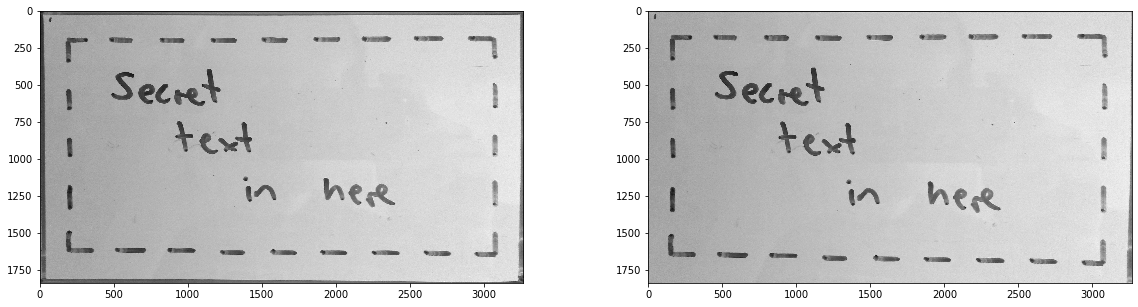

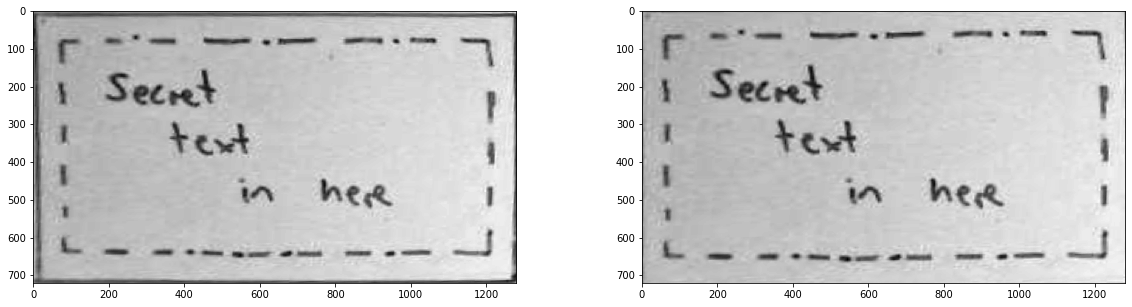

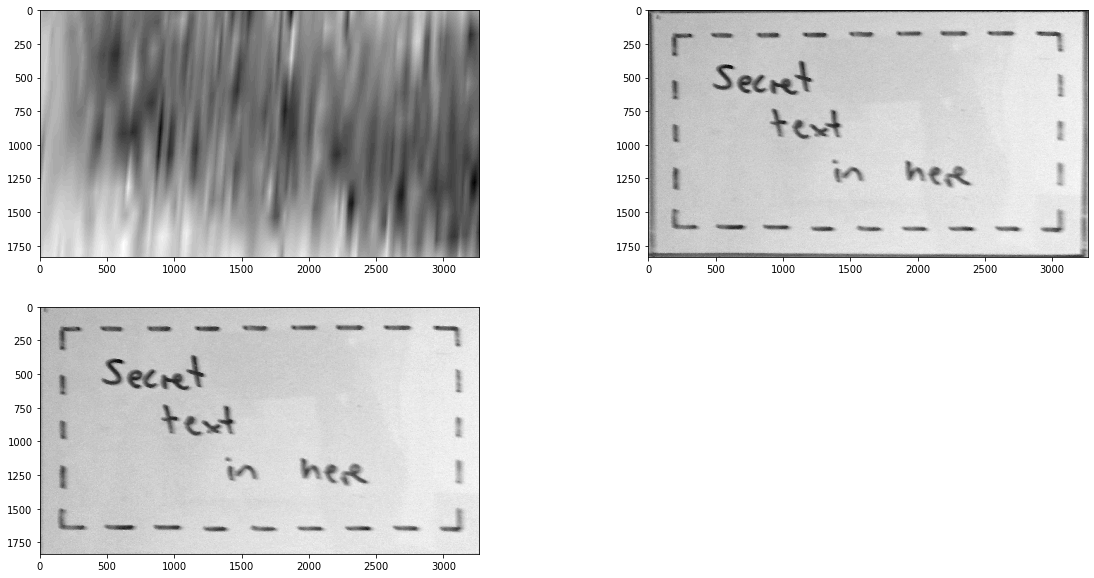

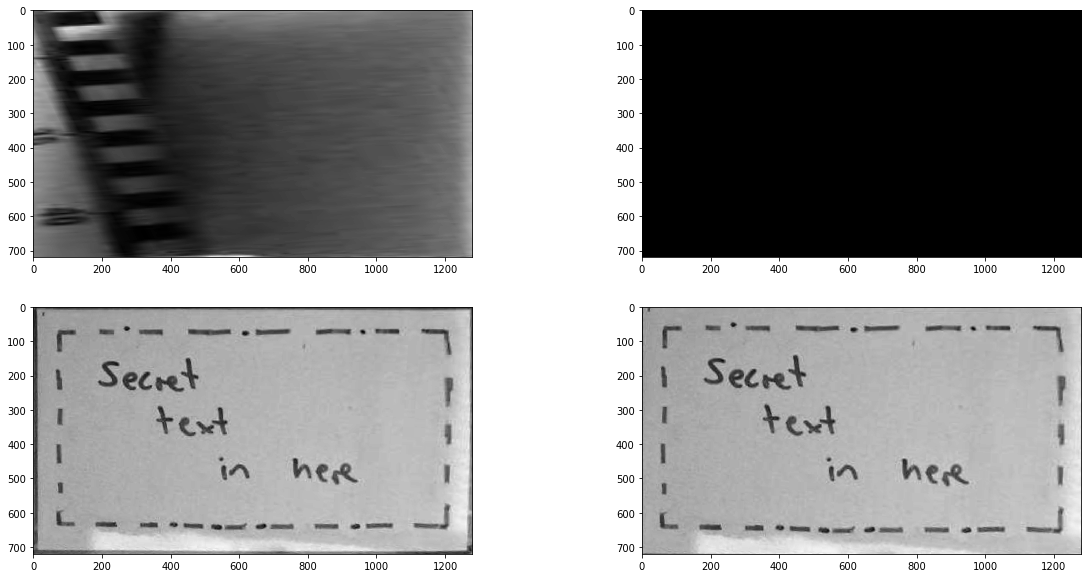

In [25]:
def create_transformed_subimages(img, rectangles):
    sub_imgs = []
    rows, cols = img.shape
    
    for rect in rectangles:
        pts1 = order_points([rect[0][0],rect[1][0],rect[2][0],rect[3][0]])
        pts2 = np.float32([[0, 0], [cols, 0], [cols, rows], [0, rows]])
        m = cv.getPerspectiveTransform(pts1, pts2)
        dst = cv.warpPerspective(img, m, (cols, rows))
        sub_imgs.append(dst)
    
    return sub_imgs

subimages_array = [create_transformed_subimages(img, rectangles) for img, rectangles in zip(grayscale_imgs, rectangles_array)]

for subimages in subimages_array:
    plot_imgs(subimages)


### Inner margin
Define an inner margin inside the rectangle, where dashed line is allowed.

![alt text](https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-secret-whiteboard/master/img/sample1_5_1_split_image_to_parts.png)

### Image Extraction 
Extract all margin areas (left, right, bottom, top) as separate images.

![alt text](https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-secret-whiteboard/master/img/sample1_5_3_left_rotated.png)

![alt text](https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-secret-whiteboard/master/img/sample1_5_3_right_rotated.png)

![alt text](https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-secret-whiteboard/master/img/sample1_5_2_bottom.png)

![alt text](https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-secret-whiteboard/master/img/sample1_5_2_top.png)

### Detect dashed lines
- Create a 1-dimensional array with the same width as the current area.
- Initialize the array with zeroes.
- Detect contours of line segments.
- Get leftmost and rightmost pixel of the outline.
- Set all corresponding x values in the array to 255 (interval $[leftmost,rightmost]$).

![alt text](https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-secret-whiteboard/master/img/sample1_5_3_left_rotated_1d_array.png)

## 5. Image Manipulation
Draw and fill out a rectangular shape (bounding rectangle of outer contour) for every detected pattern.

![alt text](https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-secret-whiteboard/master/img/sample1_6_final_picture.png)